In [28]:
import numpy as np
import matplotlib.pyplot as plt

## Conditional Probabilities

- P(E = T|F = T, J = T, M = T) α P(E) * P(J|E) * P(F|E) = 0.5 * 0.8 * 0.1 = 0.04
- P(E = T|F = F, J = T, M = T) α P(E) * P(J|E) * P(F|E) = 0.5 * 0.8 * 0.9 = 0.36
- P(F = T | E = T, J=T, M = T) α P(F|E) * P(M|F,J) = 0.1 * 0.95 = 0.095
- P(F = T | E = F, J=T, M = T) α P(F|E) * P(M|F,J) = 0.5 * 0.95 = 0.475

In [2]:
# Local Probability Distributions (LPDs) from the Bayesian Network
P_E = {True: 0.5, False: 0.5}  # P(E)
P_F_given_E = {True: {True: 0.1, False: 0.9}, False: {True: 0.5, False: 0.5}}  # P(F | E)
P_J_given_E = {True: {True: 0.8, False: 0.2}, False: {True: 0.1, False: 0.9}}  # P(J | E)
P_M_given_F_J = {
    (True, True): 0.95,
    (True, False): 0.9,
    (False, True): 0.9,
    (False, False): 0.1,
}  # P(M | F, J)

## Gibbs Sampler

In [45]:
# Gibbs sampler 
num_samples = 100

def gibbs_sampler(num_samples, burn_in=0, thinning=1):
    samples = []

    F = np.random.choice([True, False])
    E = np.random.choice([True, False])

    J = True
    M = True

    for i in range(num_samples + burn_in):
        # Sample E
        P_E_given_F_J_M = {
            True: P_E[True] * P_J_given_E[True][J] * P_F_given_E[True][F],
            False: P_E[False] * P_J_given_E[False][J] * P_F_given_E[False][F],
        }

        # Normalize
        total_E = sum(P_E_given_F_J_M.values())
        P_E_given_F_J_M = {k: v / total_E for k, v in P_E_given_F_J_M.items()}

        # New E
        E = np.random.choice([True, False], p=[P_E_given_F_J_M[True], P_E_given_F_J_M[False]])

        # Sample F
        P_F_given_E_J_M = {
            True: P_F_given_E[E][True] * P_M_given_F_J[(True, J)],
            False: P_F_given_E[E][False] * P_M_given_F_J[(False, J)],
        }

        # Normalize
        total_F = sum(P_F_given_E_J_M.values())
        P_F_given_E_J_M = {k: v / total_F for k, v in P_F_given_E_J_M.items()}

        # New F
        F = np.random.choice([True, False], p=[P_F_given_E_J_M[True], P_F_given_E_J_M[False]])

       # Store samples after burn-in and thinning
        if i >= burn_in and (i - burn_in) % thinning == 0:
            samples.append((F, E))

    return samples




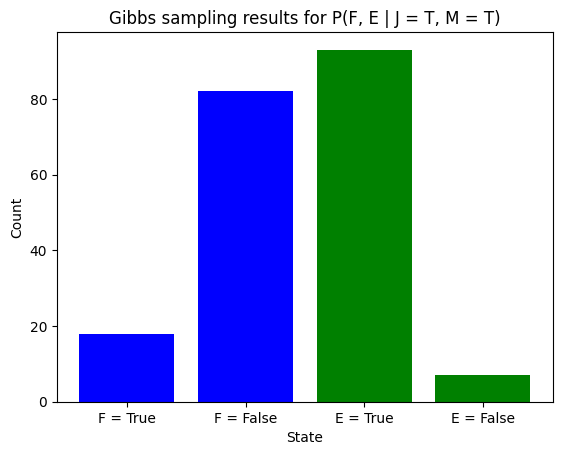

In [8]:
# Plotting the results
F_counts = {True: 0, False: 0}
E_counts = {True: 0, False: 0}

for F, E in samples:
    F_counts[F] += 1
    E_counts[E] += 1

labels = ["F = True", "F = False", "E = True", "E = False"]
counts = [F_counts[True], F_counts[False], E_counts[True], E_counts[False]]

plt.bar(labels, counts, color = ['blue', 'blue', 'green', 'green'])
plt.title("Gibbs sampling results for P(F, E | J = T, M = T)")
plt.ylabel("Count")
plt.xlabel("State")
plt.show()

In [44]:
def estimate_probability(samples):
    F_true_count = sum(1 for sample in samples if sample[0])
    return F_true_count / len(samples)

In [10]:
# Estimate P(F = True | J = True, M = True) without burn-in and thining-out
estimate_probability(samples)

0.18

In [22]:
num_samples = 50000
# Run Gibbs Sampler for two chains
samples_chain1 = gibbs_sampler(num_samples)
samples_chain2 = gibbs_sampler(num_samples)

## Relative frequencies

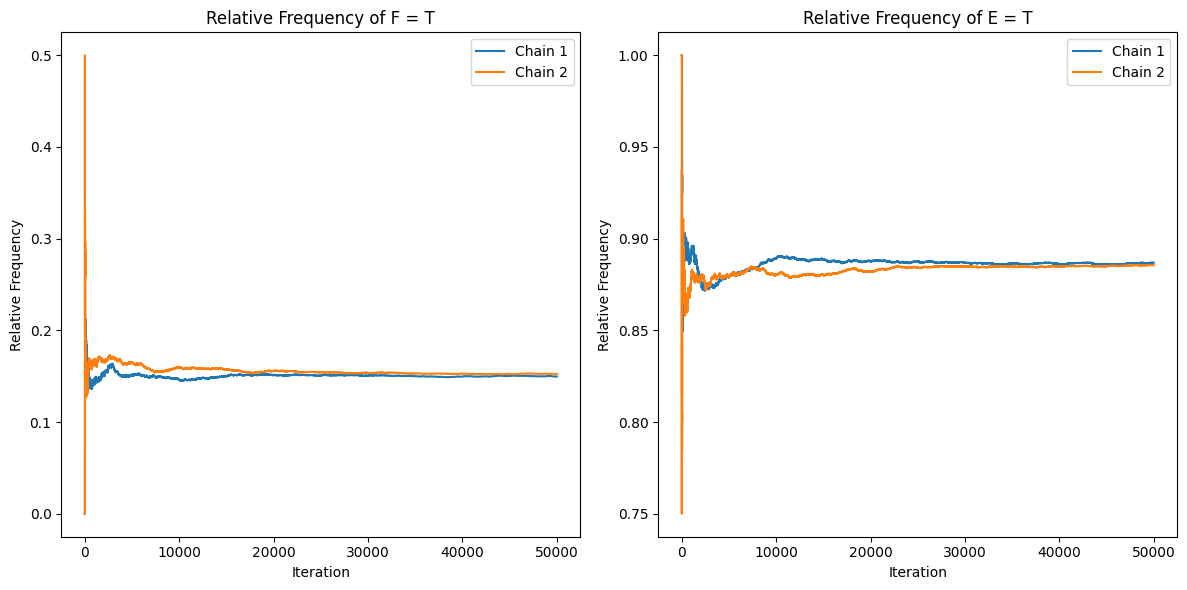

In [24]:
# Compute relative frequencies
relative_freq_F_chain1 = [sum(1 for f, _ in samples_chain1[:i] if f) / i for i in range(1, num_samples + 1)]
relative_freq_F_chain2 = [sum(1 for f, _ in samples_chain2[:i] if f) / i for i in range(1, num_samples + 1)]
relative_freq_E_chain1 = [sum(1 for _, e in samples_chain1[:i] if e) / i for i in range(1, num_samples + 1)]
relative_freq_E_chain2 = [sum(1 for _, e in samples_chain2[:i] if e) / i for i in range(1, num_samples + 1)]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(relative_freq_F_chain1, label="Chain 1")
plt.plot(relative_freq_F_chain2, label="Chain 2")
plt.title("Relative Frequency of F = T")
plt.xlabel("Iteration")
plt.ylabel("Relative Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(relative_freq_E_chain1, label="Chain 1")
plt.plot(relative_freq_E_chain2, label="Chain 2")
plt.title("Relative Frequency of E = T")
plt.xlabel("Iteration")
plt.ylabel("Relative Frequency")
plt.legend()

plt.tight_layout()
plt.show()

suggested burn-in based on relative frequencies: 30 000 iterations

## Gelman and Rubin diagnostic

In [37]:
def gelman_rubin(chains):
    num_chains = len(chains)
    num_samples = len(chains[0])

    # Compute within-chain variance W
    chain_means = np.array([np.mean(chain, axis=0) for chain in chains])
    within_var = np.mean([np.var(chain, axis=0, ddof=1) for chain in chains], axis=0)

    # Compute between-chain variance B
    overall_mean = np.mean(chain_means, axis=0)
    between_var = num_samples * np.var(chain_means, axis=0, ddof=1)

    # Estimate the target variance V
    var_target = ((num_samples - 1) / num_samples) * within_var + (1 / num_samples) * between_var

    # Compute Potential Scale Reduction Factor R_hat
    r_hat = np.sqrt(var_target / within_var)
    return r_hat

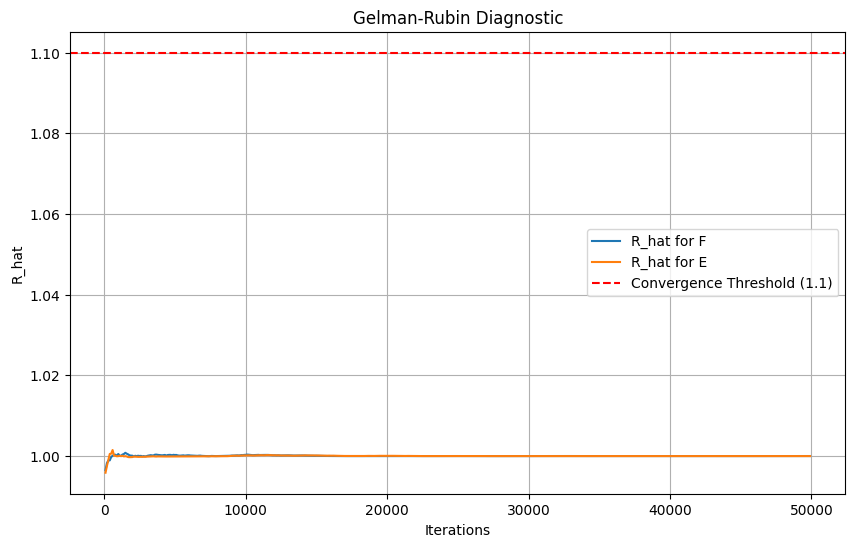

In [39]:
samples_chain1 = np.array(samples_chain1)
samples_chain2 = np.array(samples_chain2)

# Combine chains into a list
chains = [samples_chain1, samples_chain2]

r_hat_values = []
for t in range(100, num_samples, 100):  # Compute every 100 iterations to save computation
    truncated_chains = [chain[:t] for chain in chains]
    r_hat = gelman_rubin(truncated_chains)
    r_hat_values.append(r_hat)

# Plot the R_hat values over iterations
r_hat_values = np.array(r_hat_values)
plt.figure(figsize=(10, 6))
plt.plot(range(100, num_samples, 100), r_hat_values[:, 0], label="R_hat for F")
plt.plot(range(100, num_samples, 100), r_hat_values[:, 1], label="R_hat for E")
plt.axhline(1.1, color="red", linestyle="--", label="Convergence Threshold (1.1)")
plt.xlabel("Iterations")
plt.ylabel("R_hat")
plt.title("Gelman-Rubin Diagnostic")
plt.legend()
plt.grid()
plt.show()

suggested bburn-in based on the Gelman-Rubin Diagnostic: 10 000 iterations

## Autocorrelation

In [42]:
def autocorrelation(samples, max_lag):
    n = len(samples)
    mean = np.mean(samples)
    autocorr = []

    for lag in range(max_lag + 1):
        cov = np.sum((samples[:n - lag] - mean) * (samples[lag:] - mean)) / (n - lag)
        var = np.sum((samples - mean) ** 2) / n
        autocorr.append(cov / var)

    return autocorr


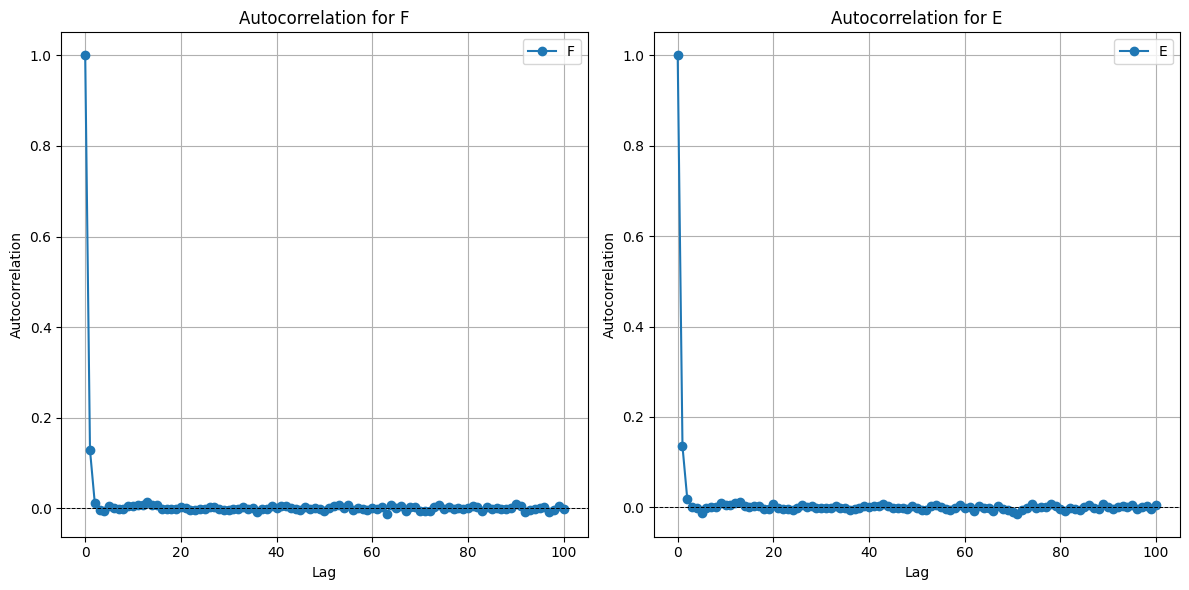

In [43]:
max_lag = 100

# Extract F and E samples from one of the chains 
F_samples = samples_chain1[:, 0]
E_samples = samples_chain1[:, 1]

F_autocorr = autocorrelation(F_samples, max_lag)
E_autocorr = autocorrelation(E_samples, max_lag)

# Plot autocorrelation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(max_lag + 1), F_autocorr, marker="o", label="F")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation for F")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(max_lag + 1), E_autocorr, marker="o", label="E")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation for E")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Suggest interval for approximately independent samples
threshold = 0.1  
F_indep_interval = np.where(np.array(F_autocorr) < threshold)[0][0]
E_indep_interval = np.where(np.array(E_autocorr) < threshold)[0][0]

print(f"Suggested interval for approximately independent samples:")
print(f"F: Every {F_indep_interval} samples")
print(f"E: Every {E_indep_interval} samples")


Suggested interval for approximately independent samples:
F: Every 2 samples
E: Every 2 samples


## Implementing burn-im and thinning-out

In [46]:
# Estimate P(F = True | J = True, M = True)
samples_burn_thin = gibbs_sampler(num_samples=100, burn_in=50, thinning=2)
prob_F_given_JM_burn_thin = estimate_probability(samples_burn_thin)

In [47]:
prob_F_given_JM_burn_thin

0.3

The estimated probability is 2 times a much as the previous calculated probability (0.18).

In [48]:
samples_burn_thin = gibbs_sampler(num_samples=100, burn_in=50, thinning=1)
prob_F_given_JM_burn_thin = estimate_probability(samples_burn_thin)

In [49]:
prob_F_given_JM_burn_thin

0.21

When reducing the thinning, the result is similar to the first calculated probabaility (0.18). So it is the crucial paremter while using the Gibbs Sampler.

In [50]:
def compute_analytical_probability():
    P_F_true_J_M = 0  # To store numerator
    P_J_M = 0         # To store denominator

    for E in [True, False]:  # Iterate over E
        for F in [True, False]:  # Iterate over F
            joint_prob = (
                P_E[E] *                     # P(E)
                P_F_given_E[E][F] *          # P(F | E)
                P_J_given_E[E][J] *          # P(J | E)
                P_M_given_F_J[(F, J)]        # P(M | F, J)
            )
            P_J_M += joint_prob              # Add to denominator
            if F:                            # If F = True, add to numerator
                P_F_true_J_M += joint_prob

    return P_F_true_J_M / P_J_M

In [51]:
analytical_result = compute_analytical_probability()
analytical_result

0.15125535823637473

We can treat analytical approach as a "ground truth" to which we can compare sampling results. The closest to the ground truth is the first sampling approach without using burn-in and thinning-out. Poor aacuracy while using burn-in and thinning might be the result of the small number of iterations (100).